import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from sklearn import preprocessing
import pylab as pl
import scipy.optimize as opt
%matplotlib inline

# Load Data From CSV File

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,No.,material,Formula,CrystalSystem,bulk,shear,young,poisson,Hexp,best,y_cs,y_gap,y_den,y_csbg,y_csden,y_bgden
0,1,mp-66,Diamond,cubic,435.3,520.5,1116.5,0.07,96.0,H5,H1a,H2,H2,H2,H5,H2
1,2,mp-30148,BC2N,orthorhombic,361.0,422.7,912.1,0.08,76.0,H5,H2,H2,H2,H2,H2,H2
2,3,mp-629458,BC2N,orthorhombic,361.6,409.0,891.1,0.09,76.0,H5,H2,H1a,H2,H2,H2,H5
3,4,mp-1018649,c-BC5,trigonal,405.8,378.2,865.6,0.14,71.0,H2,H2,H4,H2,H2,H2,H2
4,5,mp-1639,BN,cubic,408.0,374.5,860.2,0.15,63.0,H2,H1a,H2,H2,H2,H5,H2


In [3]:
df.columns

Index(['No.', 'material', 'Formula', 'CrystalSystem', 'bulk', 'shear', 'young',
       'poisson', 'Hexp', 'best', 'y_cs', 'y_gap', 'y_den', 'y_csbg',
       'y_csden', 'y_bgden'],
      dtype='object')

# Feature set and Normalize Data

In [4]:
X = df[['bulk','shear','young','poisson']] .values  #.astype(float)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
y = df['best'].values

In [5]:
X.shape

(143, 4)

# Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (114, 4) (114,)
Test set: (29, 4) (29,)


# Hardness Function

In [7]:
def H1a(B,G,Y,v):
    return 0.1475*G

def H1b(B,G,Y,v):
    return 0.067*Y

def H2(B,G,Y,v):
    return (0.1769*G)-2.899

def H3(B,G,Y,v):
    return 0.0635*Y

def H4(B,G,Y,v):
    return ((1-2*v)*B)/(6*(1+v))

def H5(B,G,Y,v):
    k = G/B
    return (2*np.power(k*k*G,0.585))-3

lookup={"H1a":H1a, "H1b":H1b, "H2":H2, "H3":H3, "H4":H4, "H5":H5}

# K-Nearest Neighbors

In [8]:
# Optimization of K for MAE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 10
mean_err = np.zeros((Ks-1))
std_dev = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X)
    Hpred = np.zeros(143)
    diff = np.zeros(143)
    for i in range(0,142):
        function = lookup[yhat[i]]
        Hpred[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
        diff[i] = np.abs(df.Hexp[i]-Hpred[i])
    mean_err[n-1] = metrics.mean_absolute_error(df.Hexp, Hpred)
    std_dev[n-1] = np.std(diff)
print('Mean abs error',mean_err)
print('Standart deviation',std_dev)
print( "The best accuracy was with", mean_err[2], "with k=3")

Mean abs error [1.56 2.49 2.38 2.51 2.33 2.43 2.73 3.04 3.38]
Standart deviation [2.05 3.03 2.66 2.88 2.67 2.64 3.72 4.73 5.68]
The best accuracy was with 2.3829171955056743 with k=3


Text(0.5, 0, 'Number of Neighbors (K)')

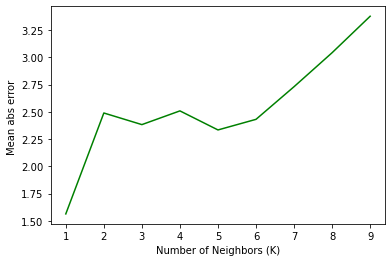

In [9]:
# Plot the model accuracy for a different number of neighbors
plt.plot(range(1,Ks),mean_err,'g')
plt.ylabel('Mean abs error ')
plt.xlabel('Number of Neighbors (K)')

In [10]:
k=3
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_0 = neigh.predict(X_test)
yhat_prob_0 = neigh.predict_proba(X_test)
y_knn = neigh.predict(X)

In [11]:
H_knn = np.zeros(143)
for i in range(0,142):
    function = lookup[y_knn[i]]
    H_knn[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_knn = np.abs(df.Hexp - H_knn)
stddev_knn = np.std(error_knn)

In [12]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, neigh.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, neigh.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_knn))
print('Standard deviation = ', stddev_knn)

Train set Accuracy =  0.5964912280701754
Test set Accuracy  =  0.20689655172413793
All set Accuracy   =  0.5174825174825175
Mean abs error     =  2.3829171955056743
Standard deviation =  2.649117142934889


# Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
hardnessTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
hardnessTree.fit(X_train,y_train)
yhat_1 = hardnessTree.predict(X_test)
yhat_prob_1 = hardnessTree.predict_proba(X_test)
y_tree = hardnessTree.predict(X)

In [14]:
H_tree = np.zeros(143)
for i in range(0,142):
    function = lookup[y_tree[i]]
    H_tree[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_tree = np.abs(df.Hexp - H_tree)
stddev_tree = np.std(error_tree)

In [15]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, hardnessTree.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, hardnessTree.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, hardnessTree.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_tree))
print('Standard deviation = ', stddev_tree)

Train set Accuracy =  0.49122807017543857
Test set Accuracy  =  0.27586206896551724
All set Accuracy   =  0.44755244755244755
Mean abs error     =  2.964421320670167
Standard deviation =  3.517790107510122


# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_2 = LR.predict(X_test)
yhat_prob_2 = LR.predict_proba(X_test)
y_log = LR.predict(X)

In [17]:
H_log = np.zeros(143)
for i in range(0,142):
    function = lookup[y_log[i]]
    H_log[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_log = np.abs(df.Hexp - H_log)
stddev_log = np.std(error_log)

In [18]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, LR.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, LR.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_log))
print('Standard deviation = ', stddev_log)

Train set Accuracy =  0.34210526315789475
Test set Accuracy  =  0.13793103448275862
All set Accuracy   =  0.3006993006993007
Mean abs error     =  3.5130817254272433
Standard deviation =  4.371089877600043


# Support Vector Machine

In [19]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',probability=True)
clf.fit(X_train, y_train) 
yhat_3 = clf.predict(X_test)
yhat_prob_3 = clf.predict_proba(X_test)
y_svm = clf.predict(X)

In [20]:
H_svm = np.zeros(143)
for i in range(0,142):
    function = lookup[y_svm[i]]
    H_svm[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_svm = np.abs(df.Hexp - H_svm)
stddev_svm = np.std(error_svm)

In [21]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, clf.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, clf.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_svm))
print('Standard deviation = ', stddev_svm)

Train set Accuracy =  0.37719298245614036
Test set Accuracy  =  0.13793103448275862
All set Accuracy   =  0.32867132867132864
Mean abs error     =  2.9461225341553
Standard deviation =  3.0983685189082655


# Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train) 
yhat_4 = rfc.predict(X_test)
yhat_prob_4 = rfc.predict_proba(X_test)
y_rfc = rfc.predict(X)

In [23]:
H_rfc = np.zeros(143)
for i in range(0,142):
    function = lookup[y_rfc[i]]
    H_rfc[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_rfc = np.abs(df.Hexp - H_rfc)
stddev_rfc = np.std(error_rfc)

In [24]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, rfc.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, rfc.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, rfc.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_rfc))
print('Standard deviation = ', stddev_rfc)

Train set Accuracy =  0.4824561403508772
Test set Accuracy  =  0.13793103448275862
All set Accuracy   =  0.4125874125874126
Mean abs error     =  3.27617376351088
Standard deviation =  4.259220998302396


# AdaBoost Classifier

In [25]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train, y_train) 
yhat_5 = ada.predict(X_test)
yhat_prob_5 = ada.predict_proba(X_test)
y_ada = ada.predict(X)

In [26]:
H_ada = np.zeros(143)
for i in range(0,142):
    function = lookup[y_ada[i]]
    H_ada[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_ada = np.abs(df.Hexp - H_ada)
stddev_ada = np.std(error_ada)

In [27]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, ada.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, ada.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, ada.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_ada))
print('Standard deviation = ', stddev_ada)

Train set Accuracy =  0.3333333333333333
Test set Accuracy  =  0.06896551724137931
All set Accuracy   =  0.27972027972027974
Mean abs error     =  3.903780142190854
Standard deviation =  3.981799279850908


# Gradient Boosting Classifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.6, max_depth=1, random_state=0)
gbc.fit(X_train, y_train) 
yhat_6 = gbc.predict(X_test)
yhat_prob_6 = gbc.predict_proba(X_test)
y_gbc = gbc.predict(X)

In [29]:
H_gbc = np.zeros(143)
for i in range(0,142):
    function = lookup[y_gbc[i]]
    H_gbc[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
error_gbc = np.abs(df.Hexp - H_gbc)
stddev_gbc = np.std(error_gbc)

In [30]:
from sklearn import metrics
print("Train set Accuracy = ", metrics.accuracy_score(y_train, gbc.predict(X_train)))
print("Test set Accuracy  = ", metrics.accuracy_score(y_test, gbc.predict(X_test)))
print("All set Accuracy   = ", metrics.accuracy_score(y, gbc.predict(X)))
print("Mean abs error     = ", metrics.mean_absolute_error(df.Hexp, H_gbc))
print('Standard deviation = ', stddev_gbc)

Train set Accuracy =  0.9824561403508771
Test set Accuracy  =  0.3103448275862069
All set Accuracy   =  0.8461538461538461
Mean abs error     =  1.5689441441668102
Standard deviation =  2.00285909629821


# Comparision Metrics

In [31]:
maerror = np.zeros(7)
acscore = np.zeros(7)
jaccard = np.zeros(7)
f1score = np.zeros(7)
logloss = np.zeros(7)
stddev  = np.zeros(7)

In [32]:
from sklearn import metrics
maerror[0] = metrics.mean_absolute_error(df.Hexp, H_knn)
maerror[1] = metrics.mean_absolute_error(df.Hexp, H_tree)
maerror[2] = metrics.mean_absolute_error(df.Hexp, H_log)
maerror[3] = metrics.mean_absolute_error(df.Hexp, H_svm)
maerror[4] = metrics.mean_absolute_error(df.Hexp, H_rfc)
maerror[5] = metrics.mean_absolute_error(df.Hexp, H_ada)
maerror[6] = metrics.mean_absolute_error(df.Hexp, H_gbc)

In [33]:
mean_knn  = np.abs(df.Hexp - H_knn)
mean_tree = np.abs(df.Hexp - H_tree)
mean_log  = np.abs(df.Hexp - H_log)
mean_svm  = np.abs(df.Hexp - H_svm)
mean_rfc  = np.abs(df.Hexp - H_rfc)
mean_ada  = np.abs(df.Hexp - H_ada)
mean_gbc  = np.abs(df.Hexp - H_gbc)

In [34]:
stddev[0] = np.std(mean_knn)
stddev[1] = np.std(mean_tree)
stddev[2] = np.std(mean_log)
stddev[3] = np.std(mean_svm)
stddev[4] = np.std(mean_rfc)
stddev[5] = np.std(mean_ada)
stddev[6] = np.std(mean_gbc)

In [35]:
from sklearn import metrics
acscore[0] = metrics.accuracy_score(y_test, yhat_0)
acscore[1] = metrics.accuracy_score(y_test, yhat_1)
acscore[2] = metrics.accuracy_score(y_test, yhat_2)
acscore[3] = metrics.accuracy_score(y_test, yhat_3)
acscore[4] = metrics.accuracy_score(y_test, yhat_4)
acscore[5] = metrics.accuracy_score(y_test, yhat_5)
acscore[6] = metrics.accuracy_score(y_test, yhat_6)

In [36]:
from sklearn.metrics import jaccard_score
jaccard[0] = jaccard_score(y_test, yhat_0, average='micro')
jaccard[1] = jaccard_score(y_test, yhat_1, average='micro')
jaccard[2] = jaccard_score(y_test, yhat_2, average='micro')
jaccard[3] = jaccard_score(y_test, yhat_3, average='micro')
jaccard[4] = jaccard_score(y_test, yhat_4, average='micro')
jaccard[5] = jaccard_score(y_test, yhat_5, average='micro')
jaccard[6] = jaccard_score(y_test, yhat_6, average='micro')

In [37]:
from sklearn.metrics import log_loss
logloss[0] = log_loss(y_test, yhat_prob_0)
logloss[1] = log_loss(y_test, yhat_prob_1)
logloss[2] = log_loss(y_test, yhat_prob_2)
logloss[3] = log_loss(y_test, yhat_prob_3)
logloss[4] = log_loss(y_test, yhat_prob_4)
logloss[5] = log_loss(y_test, yhat_prob_5)
logloss[6] = log_loss(y_test, yhat_prob_6)

In [38]:
from sklearn.metrics import f1_score
f1score[0] = f1_score(y_test, yhat_0, average='weighted') 
f1score[1] = f1_score(y_test, yhat_1, average='weighted') 
f1score[2] = f1_score(y_test, yhat_2, average='weighted') 
f1score[3] = f1_score(y_test, yhat_3, average='weighted') 
f1score[4] = f1_score(y_test, yhat_4, average='weighted') 
f1score[5] = f1_score(y_test, yhat_5, average='weighted') 
f1score[6] = f1_score(y_test, yhat_6, average='weighted') 

In [39]:
print('                       KNN  Tree  LR  SVM   RF  ADA  GBC')
print('Mean Absolu Error  = ', maerror)
print('Standard deviation = ', stddev)

                       KNN  Tree  LR  SVM   RF  ADA  GBC
Mean Absolu Error  =  [2.38 2.96 3.51 2.95 3.28 3.9  1.57]
Standard deviation =  [2.65 3.52 4.37 3.1  4.26 3.98 2.  ]


In [40]:
print('                      KNN  Tree  LR  SVM   RF  ADA  GBC')
print('Test set Accuracy = ', acscore)
print('Jaccard index     = ', jaccard)
print('f1-score          = ', f1score)
print('Log loss          = ', logloss)

                      KNN  Tree  LR  SVM   RF  ADA  GBC
Test set Accuracy =  [0.21 0.28 0.14 0.14 0.14 0.07 0.31]
Jaccard index     =  [0.12 0.16 0.07 0.07 0.07 0.04 0.18]
f1-score          =  [0.18 0.23 0.1  0.04 0.1  0.08 0.28]
Log loss          =  [20.62  2.92  1.78  1.79  1.79  1.71  2.49]


# Gradient Boosting Regressor

In [41]:
X = df[['bulk','shear','young','poisson']] .values  #.astype(float)
y = df['Hexp'].values

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [43]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
H_gbr = reg.predict(X_test)
H_gbr

array([18.65,  2.95, 26.5 ,  9.21, 19.48, 29.63,  1.77,  8.09,  7.66,
        7.96,  2.51, 31.36, 23.82,  3.59,  2.95, 23.27,  4.32,  2.44,
        3.07, 23.36, 15.28,  5.63,  7.69, 26.61,  7.75, 27.75,  1.92,
        1.95, 10.88, 30.64, 76.03, 24.09, 34.75, 28.61, 10.6 ,  6.08])

In [44]:
y_test

array([15.2,  1.7, 30. , 10.7, 27. , 34. ,  2.2, 10.5, 14. ,  2.8,  4.5,
       25.5, 33. ,  4. ,  4.4, 20. ,  5.8,  1.4,  1.5, 25.6,  9.3,  5.4,
        9.5, 22.5,  9.4, 29. ,  2. ,  2.4, 15.2, 26.5, 76. , 22. , 50. ,
       33. , 15.5,  5.5])

In [45]:
H_gbr = reg.predict(X)
MAE_gbr = metrics.mean_absolute_error(df.Hexp, H_gbr)
error_gbr = np.abs(df.Hexp - H_gbr)
stddev_gbr = np.std(error_gbr)
print('Mean Absolu Error  = ', MAE_gbr)
print('Standard deviation = ', stddev_gbr)

Mean Absolu Error  =  1.2833321096132309
Standard deviation =  1.9397923260928762


# The best possible result

In [46]:
y_best = df['best'].values  #.astype(float)
y_best.size

143

In [47]:
Hbest = np.zeros(y_best.size)
for i in range(0,y_best.size-1):
    function = lookup[y_best[i]]
    Hbest[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])

In [48]:
from sklearn.metrics import mean_absolute_error
MAE_best = mean_absolute_error(df.Hexp, Hbest)
error_min = np.abs(df.Hexp - Hbest)
stddev_best = np.std(error_min)
print('Mean Absolu Error  = ', MAE_best)
print('Standard deviation = ', stddev_best)

Mean Absolu Error  =  1.1560860248551077
Standard deviation =  1.3667704693307334


# Classic calculator

In [49]:
df.columns

Index(['No.', 'material', 'Formula', 'CrystalSystem', 'bulk', 'shear', 'young',
       'poisson', 'Hexp', 'best', 'y_cs', 'y_gap', 'y_den', 'y_csbg',
       'y_csden', 'y_bgden'],
      dtype='object')

In [50]:
y_best = df['best'].values  #.astype(float)
y_cs = df['y_cs'].values  #.astype(float)
y_gap = df['y_gap'].values  #.astype(float)
y_den = df['y_den'].values  #.astype(float)
y_csbg = df['y_csbg'].values  #.astype(float)
y_csden = df['y_csden'].values  #.astype(float)
y_bgden = df['y_bgden'].values  #.astype(float)

In [51]:
H_best = np.zeros(y_best.size)
H_cs = np.zeros(y_best.size)
H_gap = np.zeros(y_best.size)
H_den = np.zeros(y_best.size)
H_csbg = np.zeros(y_best.size)
H_csden = np.zeros(y_best.size)
H_bgden = np.zeros(y_best.size)

In [52]:
for i in range(0,y_best.size-1):
    function = lookup[y_best[i]]
    H_best[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_cs[i]]
    H_cs[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_gap[i]]
    H_gap[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_den[i]]
    H_den[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_csbg[i]]
    H_csbg[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_csden[i]]
    H_csden[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])
    function = lookup[y_bgden[i]]
    H_bgden[i] = function(df.bulk[i], df.shear[i], df.young[i], df.poisson[i])    

In [53]:
from sklearn.metrics import mean_absolute_error
MAE_best = mean_absolute_error(df.Hexp, H_best)
MAE_cs = mean_absolute_error(df.Hexp, H_cs)
MAE_gap = mean_absolute_error(df.Hexp, H_gap)
MAE_den = mean_absolute_error(df.Hexp, H_den)
MAE_csbg = mean_absolute_error(df.Hexp, H_csbg)
MAE_csden = mean_absolute_error(df.Hexp, H_csden)
MAE_bgden = mean_absolute_error(df.Hexp, H_bgden)

In [54]:
error_min_best = np.abs(df.Hexp - H_best)
error_min_cs = np.abs(df.Hexp - H_cs)
error_min_gap = np.abs(df.Hexp - H_gap)
error_min_den = np.abs(df.Hexp - H_den)
error_min_csbg = np.abs(df.Hexp - H_csbg)
error_min_csden = np.abs(df.Hexp - H_csden)
error_min_bgden = np.abs(df.Hexp - H_bgden)

In [55]:
stddev_best = np.std(error_min_best)
stddev_cs = np.std(error_min_cs)
stddev_gap = np.std(error_min_gap)
stddev_den = np.std(error_min_den)
stddev_csbg = np.std(error_min_csbg)
stddev_csden = np.std(error_min_csden)
stddev_bgden = np.std(error_min_bgden)

In [56]:
print('MAE Best possible result = ', MAE_best)
print('MAE Crystal System       = ', MAE_cs)
print('MAE Bandgap              = ', MAE_gap)
print('MAE Density              = ', MAE_den)
print('MAE Csys and bandgap     = ', MAE_csbg)
print('MAE Csys and density     = ', MAE_csden)
print('MAE bandgap and density  = ', MAE_bgden)

MAE Best possible result =  1.1560860248551077
MAE Crystal System       =  2.9735907485939523
MAE Bandgap              =  3.000140543737141
MAE Density              =  2.6126027736967727
MAE Csys and bandgap     =  2.3550543704836846
MAE Csys and density     =  2.2487589408341755
MAE bandgap and density  =  2.500238697131566


In [57]:
print('Standard deviation best  = ', stddev_best)
print('Standard deviation csys  = ', stddev_cs)
print('Standard deviation gap   = ', stddev_gap)
print('Standard deviation den   = ', stddev_den)
print('Standard deviation csbg  = ', stddev_csbg)
print('Standard deviation csden = ', stddev_csden)
print('Standard deviation bgden = ', stddev_bgden)

Standard deviation best  =  1.3667704693307334
Standard deviation csys  =  3.1664893325442116
Standard deviation gap   =  3.657749000924076
Standard deviation den   =  2.697416086163109
Standard deviation csbg  =  2.6771019217911722
Standard deviation csden =  2.1826987094312007
Standard deviation bgden =  2.887459429188358


In [58]:
from sklearn import metrics
acscore_best = metrics.accuracy_score(y_best, y_best)
acscore_cs = metrics.accuracy_score(y_best, y_cs)
acscore_gap = metrics.accuracy_score(y_best, y_gap)
acscore_den = metrics.accuracy_score(y_best, y_den)
acscore_csbg = metrics.accuracy_score(y_best, y_csbg)
acscore_csden = metrics.accuracy_score(y_best, y_csden)
acscore_bgden = metrics.accuracy_score(y_best, y_bgden)

In [59]:
print('Accuracy best  = ', acscore_best)
print('Accuracy csys  = ', acscore_cs)
print('Accuracy gap   = ', acscore_gap)
print('Accuracy den   = ', acscore_den)
print('Accuracy csbg  = ', acscore_csbg)
print('Accuracy csden = ', acscore_csden)
print('Accuracy bgden = ', acscore_bgden)

Accuracy best  =  1.0
Accuracy csys  =  0.23076923076923078
Accuracy gap   =  0.24475524475524477
Accuracy den   =  0.3076923076923077
Accuracy csbg  =  0.34265734265734266
Accuracy csden =  0.34265734265734266
Accuracy bgden =  0.35664335664335667
